# Домашнее задание к занятию
## "Feature Selection" обновленное
1. Взять датасет.
2. Провести EDA
3. Построить зависимость между качеством модели и количеством отобранных признаков. Т.е. надо обучать модель на количестве признаков от одного до максимально возможного.
4. Для отбора признаков использовать следующие подходы:
 - корреляция признаков (на основе матрицы корреляции) и отбор по величине корреляции
 - отбор признаков на основе Information Value (см. статью)
 - отбор признаков на основе feature_impotance от алгоритма RandomForest
 - жадный отбор признаков по максимальному нарастанию качества модели
 - жадное отбрасывание признаков по минимальному падению качества модели

In [1]:
# Загружаем необходимые библиотеки
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_covtype
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE
from sklearn.svm import SVR
from sklearn.feature_selection import RFECV

In [2]:
# Загружаем датасет
data = fetch_covtype(download_if_missing=True)
X = pd.DataFrame(data['data'], columns=data['feature_names'])
y = pd.Series(data['target'])

In [3]:
X.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area_0,Wilderness_Area_1,Wilderness_Area_2,Wilderness_Area_3,Soil_Type_0,Soil_Type_1,Soil_Type_2,Soil_Type_3,Soil_Type_4,Soil_Type_5,Soil_Type_6,Soil_Type_7,Soil_Type_8,Soil_Type_9,Soil_Type_10,Soil_Type_11,Soil_Type_12,Soil_Type_13,Soil_Type_14,Soil_Type_15,Soil_Type_16,Soil_Type_17,Soil_Type_18,Soil_Type_19,Soil_Type_20,Soil_Type_21,Soil_Type_22,Soil_Type_23,Soil_Type_24,Soil_Type_25,Soil_Type_26,Soil_Type_27,Soil_Type_28,Soil_Type_29,Soil_Type_30,Soil_Type_31,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39
0,2596.0,51.0,3.0,258.0,0.0,510.0,221.0,232.0,148.0,6279.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2590.0,56.0,2.0,212.0,-6.0,390.0,220.0,235.0,151.0,6225.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2804.0,139.0,9.0,268.0,65.0,3180.0,234.0,238.0,135.0,6121.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2785.0,155.0,18.0,242.0,118.0,3090.0,238.0,238.0,122.0,6211.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2595.0,45.0,2.0,153.0,-1.0,391.0,220.0,234.0,150.0,6172.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
y.head()

0    5
1    5
2    2
3    2
4    5
dtype: int32

In [5]:
# Получаем основную информацию о данных в датасете
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581012 entries, 0 to 581011
Data columns (total 54 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   Elevation                           581012 non-null  float64
 1   Aspect                              581012 non-null  float64
 2   Slope                               581012 non-null  float64
 3   Horizontal_Distance_To_Hydrology    581012 non-null  float64
 4   Vertical_Distance_To_Hydrology      581012 non-null  float64
 5   Horizontal_Distance_To_Roadways     581012 non-null  float64
 6   Hillshade_9am                       581012 non-null  float64
 7   Hillshade_Noon                      581012 non-null  float64
 8   Hillshade_3pm                       581012 non-null  float64
 9   Horizontal_Distance_To_Fire_Points  581012 non-null  float64
 10  Wilderness_Area_0                   581012 non-null  float64
 11  Wilderness_Area_1         

In [6]:
# Определяем количество пропусков для каждого признака
X.isna().sum().sort_values(ascending=False).head()

Soil_Type_39         0
Wilderness_Area_3    0
Soil_Type_10         0
Soil_Type_9          0
Soil_Type_8          0
dtype: int64

По полченным значениям видим, что пропуски в данных отсутствуют, типы данных соответствуют типам признаков.

In [7]:
# Смотрим основные статистические характеристики
X.describe()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area_0,Wilderness_Area_1,Wilderness_Area_2,Wilderness_Area_3,Soil_Type_0,Soil_Type_1,Soil_Type_2,Soil_Type_3,Soil_Type_4,Soil_Type_5,Soil_Type_6,Soil_Type_7,Soil_Type_8,Soil_Type_9,Soil_Type_10,Soil_Type_11,Soil_Type_12,Soil_Type_13,Soil_Type_14,Soil_Type_15,Soil_Type_16,Soil_Type_17,Soil_Type_18,Soil_Type_19,Soil_Type_20,Soil_Type_21,Soil_Type_22,Soil_Type_23,Soil_Type_24,Soil_Type_25,Soil_Type_26,Soil_Type_27,Soil_Type_28,Soil_Type_29,Soil_Type_30,Soil_Type_31,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39
count,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000
mean,2959.365301,155.656807,14.103704,269.428217,46.418855,2350.146611,212.146049,223.318716,142.528263,1980.291226,0.448865,0.051434,0.436074,0.063627,0.005217,0.012952,0.008301,0.021335,0.002749,0.011316,0.000181,0.000308,0.001974,0.056168,0.021359,0.051584,0.030001,0.001031,0.000005,0.004897,0.005890,0.003268,0.006921,0.015936,0.001442,0.057439,0.099399,0.036622,0.000816,0.004456,0.001869,0.001628,0.198356,0.051927,0.044175,0.090392,0.077716,0.002773,0.003255,0.000205,0.000513,0.026803,0.023762,0.015060
std,279.984734,111.913721,7.488242,212.549356,58.295232,1559.254870,26.769889,19.768697,38.274529,1324.195210,0.497379,0.220882,0.495897,0.244087,0.072039,0.113066,0.090731,0.144499,0.052356,0.105775,0.013442,0.017550,0.044387,0.230245,0.144579,0.221186,0.170590,0.032092,0.002272,0.069804,0.076518,0.057077,0.082902,0.125228,0.037950,0.232681,0.299197,0.187833,0.028551,0.066605,0.043193,0.040318,0.398762,0.221879,0.205483,0.286743,0.267725,0.052584,0.056957,0.014310,0.022641,0.161508,0.152307,0.121791
min,1859.000000,0.000000,0.000000,0.000000,-173.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2809.000000,58.000000,9.000000,108.000000,7.000000,1106.000000,198.000000,213.000000,119.000000,1024.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2996.000000,127.000000,13.000000,218.000000,30.000000,1997.000000,218.000000,226.000000,143.000000,1710.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000

In [8]:
# Проверяем количество уникальных значений в каждом столбце
for item in data['feature_names']:
  print(f'Количество уникальных значений в признаке {item} - {len(X[item].unique())}')

Количество уникальных значений в признаке Elevation - 1978
Количество уникальных значений в признаке Aspect - 361
Количество уникальных значений в признаке Slope - 67
Количество уникальных значений в признаке Horizontal_Distance_To_Hydrology - 551
Количество уникальных значений в признаке Vertical_Distance_To_Hydrology - 700
Количество уникальных значений в признаке Horizontal_Distance_To_Roadways - 5785
Количество уникальных значений в признаке Hillshade_9am - 207
Количество уникальных значений в признаке Hillshade_Noon - 185
Количество уникальных значений в признаке Hillshade_3pm - 255
Количество уникальных значений в признаке Horizontal_Distance_To_Fire_Points - 5827
Количество уникальных значений в признаке Wilderness_Area_0 - 2
Количество уникальных значений в признаке Wilderness_Area_1 - 2
Количество уникальных значений в признаке Wilderness_Area_2 - 2
Количество уникальных значений в признаке Wilderness_Area_3 - 2
Количество уникальных значений в признаке Soil_Type_0 - 2
Количес

In [9]:
# Проверяем уникальные значения таргетной переменной
y.unique()

array([5, 2, 1, 7, 3, 6, 4], dtype=int32)

### Отбор по величине корреляции

In [10]:
# Определяем коэффициент корреляции Пирсона для таргетной переменной и каждого признака без учёта знака коэффициента корреляции
list_corr = []
for i in data['feature_names']:
  list_corr.append([abs(np.corrcoef(X[i], y)[0][1]), i])

In [11]:
# Обучаем модель с добавлением признаков на основе коэффициента корреляции Пирсона
corr_score = [[], []]
names = []
corr_clf = RandomForestClassifier(n_estimators=10, max_depth=10)
list_corr.sort(reverse=True)
for item in list_corr:
  names.append(item[1])
  corr_clf.fit(X[names], y)
  corr_score[0].append(len(names))
  corr_score[1].append(corr_clf.score(X[names], y))

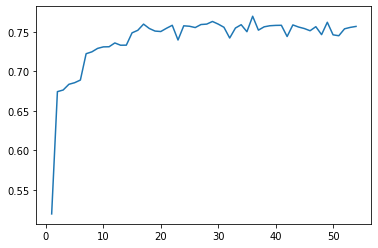

In [12]:
# Строим график
plt.plot(corr_score[0],corr_score[1])
plt.show()

###Отбор признаков на основе feature_impotance от алгоритма RandomForest

In [13]:
# Обучаем модель RandomForestRegressor
RFR_model = RandomForestRegressor()
RFR_model.fit(X, y)

RandomForestRegressor()

In [14]:
# Определяем значимость признаков
important = pd.Series(RFR_model.feature_importances_)
important.index = pd.Series(X.columns)
important.head()

Elevation                           0.332153
Aspect                              0.029823
Slope                               0.015457
Horizontal_Distance_To_Hydrology    0.045672
Vertical_Distance_To_Hydrology      0.043592
dtype: float64

In [15]:
# Обучаем модель с добавлением признаков на основе feature_impotance
RFR_score = [[], []]
names = []
RFR_clf = RandomForestClassifier(n_estimators=10, max_depth=10)
for item in important.sort_values(ascending=False).index:
  names.append(item)
  RFR_clf.fit(X[names], y)
  RFR_score[0].append(len(names))
  RFR_score[1].append(RFR_clf.score(X[names], y))

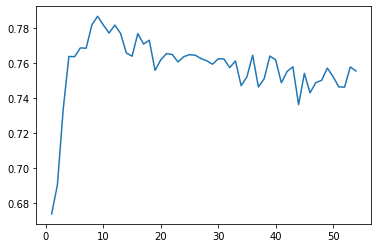

In [16]:
# Строим график
plt.plot(RFR_score[0], RFR_score[1])
plt.show()

###Жадный отбор признаков по максимальному нарастанию качества модели

В связи с длительным выполнением кода в этом алгоритме и в следующем в качестве примера будем использовать "обрезанную" версию датафрейма.

In [17]:
# Создаём модель
estimator = SVR(kernel='linear')
selector = RFE(estimator, n_features_to_select=1, step=1)

In [20]:
# Уменьшаем объём датасета
data = fetch_covtype(download_if_missing=True)
X = X[['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Hillshade_3pm']].head(500)
y = y.head(500)

In [21]:
# Обучаем модель с добавлением признаков
selector_score = [[], []]
names = list(X.columns)
new_names = []
selector_clf = RandomForestClassifier(n_estimators=10, max_depth=5)
for i in range(len(X.columns) - 1):
    selector = selector.fit(X[names], y)
    imp = pd.Series(selector.ranking_)
    imp.index = pd.Series(names)
    new_names.append(imp.sort_values().index[0])
    selector_clf.fit(X[new_names], y)
    selector_score[0].append(len(new_names))
    selector_score[1].append(selector_clf.score(X[new_names], y))
    names.remove(imp.sort_values().index[0])

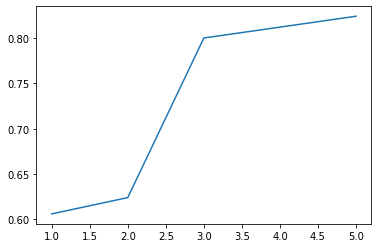

In [22]:
# Строим график
plt.plot(selector_score[0], selector_score[1])
plt.show()

###Жадное отбрасывание признаков по минимальному падению качества модели

In [23]:
# Обучаем модель с отбрасыванием признаков
selector2_score = [[], []]
names = list(X.columns)
selector2_clf = RandomForestClassifier(n_estimators=10, max_depth=5)
for i in range(len(X.columns) - 1):
    selector2_clf.fit(X[names], y)
    selector2_score[0].append(len(names))
    selector2_score[1].append(selector2_clf.score(X[names], y))
    selector = selector.fit(X[names], y)
    imp = pd.Series(selector.ranking_)
    imp.index = pd.Series(names)
    names.remove(imp.sort_values().index[-1])

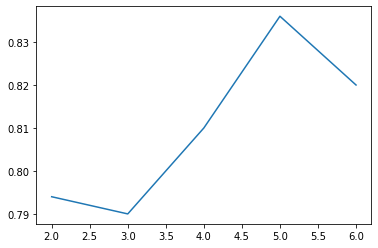

In [24]:
# Строим график
plt.plot(selector2_score[0], selector2_score[1])
plt.show()

Из полученных выше данных можно сделать вывод, что при увеличении количества признаков качество модели возрастает. Но при добавлении малозначимых признаков качество модели практически не меняется, однако, скорость обучения модели значительно возрастает. Следовательно, необходимо определять количество признаков для обеспечения требуемого качества модели.